This dataset is a collection of attributes of startup companies linked to their dependent variable of success. It can be found at https://www.kaggle.com/datasets/manishkc06/startup-success-prediction, with data provided by Ramkishan Panthena.

The purpose of this notebook is to identify aspects of the dataset that need to be cleaned or otherwise altered, followed by exploration of trends and other metrics of the data. It is important to note that this EDA will use variables in their object form, while future models will need to be trained on a numeric transformation of these objects.

In [23]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [2]:
df = pd.read_csv('startup_data.csv')
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


None

There are many attributes in this dataset that are redundant or unnecessary. For example, location information can be reduced to a single attribute of state_code. Including the city name may be too granular for this analysis, as is including coordinates and zip code. First, however, the number of NaN counts per attribute will be assessed to help determine which attributes are worth selecting over others. 

In [3]:
nas = df.isna().sum()
nas[nas > 0]

Unnamed: 6                  493
closed_at                   588
age_first_milestone_year    152
age_last_milestone_year     152
state_code.1                  1
dtype: int64

Fortunately, all of the attributes containing null values can be safely dropped. Going though the attributes to drop:

1. Beyond state_code, all other location attributes will be dropped. These are either superfluous or, like geographic coordinates, likely too granular for the purpose of this EDA.

2. The category of the business is already captured in category_code and thus the remaining category Booleans can be dropped. 

3. Information pertaining to last funding dates can be dropped, as well as closed dates, as they are causatively affected by whether the company closed or not. 

4. Information pertaining to company name or ID can be dropped.
5. There are some nonsensical attributes that can be dropped, for instance: 'Unamed: 0'. 

In [4]:
loc_to_drop = ['latitude', 'longitude', 'zip_code', 'city', 'state_code.1', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 
               'is_otherstate']
cat_to_drop = ['is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce',
              'is_biotech', 'is_consulting', 'is_othercategory']
extras_to_drop = ['Unnamed: 0', 'id', 'Unnamed: 6', 'name', 'labels', 'closed_at', 'last_funding_at', 
                  'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'object_id']

In [5]:
df = pd.read_csv('startup_data.csv')
df.drop(loc_to_drop, axis=1, inplace=True)
df.drop(cat_to_drop, axis=1, inplace=True)
df.drop(extras_to_drop, axis=1, inplace=True)

Specific dates of founding and first funding are not especially useful, as they are much too granular. These will be converted to years to get a better sense of any years that may have been optimal for either of these actions.

Additionally, the status column will be converted from string to an integer Boolean, with 1 denoting that the company was acquired.

In [6]:
df['founded_at'] = df['founded_at'].str.slice(start=-4, stop=None)
df['first_funding_at'] = df['first_funding_at'].str.slice(start=-4, stop=None)

df['status'] = df['status'].map({'acquired': 1, 'closed': 0})
df.head()

,state_code,founded_at,first_funding_at,age_first_funding_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,CA,2007,2009,2.2493,3,3,375000,3,music,0,1,0,0,0,0,1.0000,0,1
1,CA,2000,2005,5.1260,9,4,40100000,1,enterprise,1,0,0,1,1,1,4.7500,1,1
2,CA,2009,2010,1.0329,5,1,2600000,2,web,0,0,1,0,0,0,4.0000,1,1
3,CA,2002,2005,3.1315,5,3,40000000,1,software,0,0,0,1,1,1,3.3333,1,1
4,CA,2010,2010,0.0000,2,2,1300000,1,games_video,1,1,0,0,0,0,1.0000,1,0


The dataset is now much cleaner for the purpose of EDA. 

Next, a function is created to obtain success rates based on various individual categories and plot their success rates. The function allows for sorting of the returned series, as well as exclusion of data points that lack enough entries to meet a defined threshold. 

In [7]:
def attr_viz(attr, sort=False, threshold=0):
    df_attr = df[[attr, 'status']]

    attr_acq = df_attr.groupby([attr]).sum()


    attr_tot = df_attr.groupby([attr]).count()
    attr_clo = attr_tot - attr_acq


    attr_all = pd.concat([attr_acq, attr_clo], axis=1)
    attr_all.columns.values[0] = 'acquired'
    attr_all.columns.values[1] = 'closed'
    attr_all = attr_all[attr_all['acquired'] + attr_all['closed'] > threshold]
    
    attr_all.plot.bar()
    
    acq_rates = np.round(attr_acq/attr_tot, 2)
    acq_rates = pd.concat([acq_rates, attr_tot], axis=1)
    acq_rates.columns.values[0] = '% acquired'
    acq_rates.columns.values[1] = 'total'
    acq_rates = acq_rates[acq_rates['total'] > threshold]
    
    if sort:
        return acq_rates.sort_values('% acquired', ascending=False)
    
    return acq_rates

The following tables and plots have been created to allow for a simple assessment of the success rates of startups given different attributes. 

,% acquired,total
state_code,,
CA,0.68,488
CO,0.74,19
GA,0.55,11
IL,0.50,18
MA,0.77,83
NY,0.73,106
PA,0.35,17
TX,0.55,42
VA,0.54,13


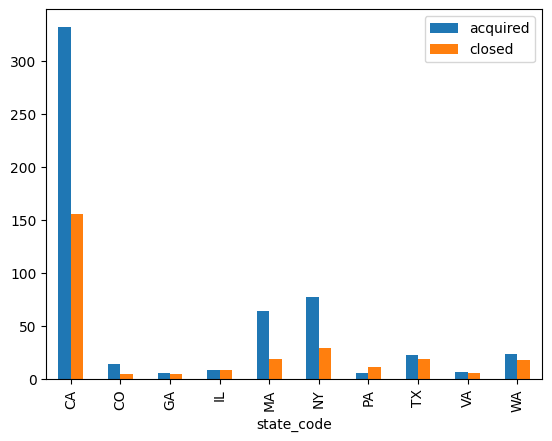

In [8]:
attr_viz('state_code', threshold=10)

,% acquired,total
category_code,,
analytics,0.84,19
security,0.79,19
enterprise,0.77,73
advertising,0.73,62
network_hosting,0.71,34
semiconductor,0.69,35
software,0.66,153
mobile,0.66,79
biotech,0.65,34


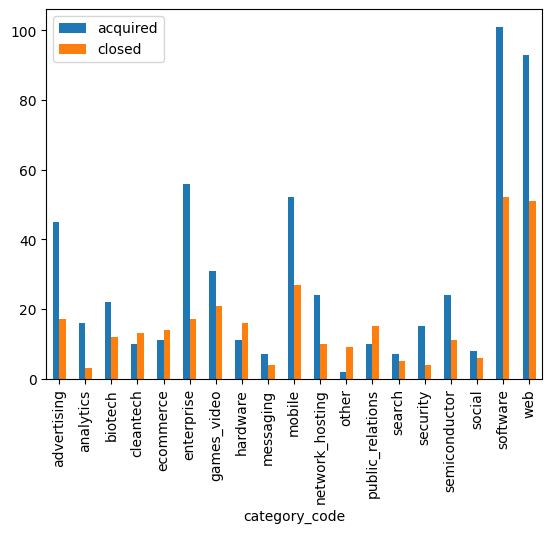

In [9]:
attr_viz('category_code', sort=True, threshold=10)

,% acquired,total
founded_at,,
1984,0.00,1
1985,0.00,1
1990,0.00,1
1992,0.00,1
1995,0.00,1
1996,0.00,3
1997,0.00,3
1998,0.00,4
1999,0.00,11


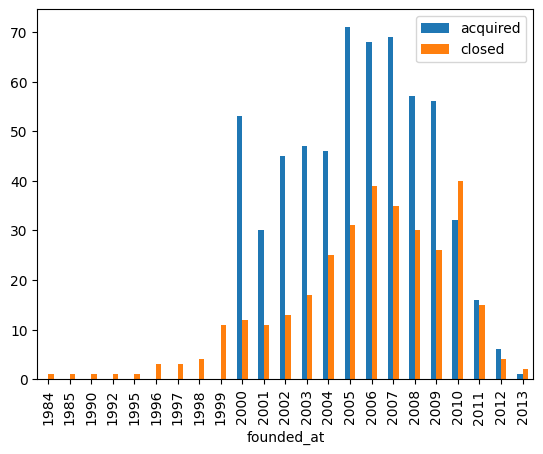

In [10]:
attr_viz('founded_at')

,% acquired,total
first_funding_at,,
2000,1.00,5
2001,0.67,3
2002,0.90,10
2003,0.89,9
2004,0.76,17
2005,0.74,148
2006,0.69,149
2007,0.61,158
2008,0.58,122


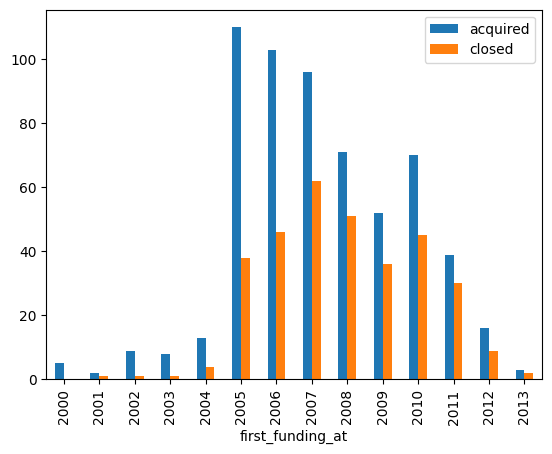

In [11]:
attr_viz('first_funding_at')

For the remainder of the EDA, the dataset will be reprocessed by dropping all object datatypes. This will allow for identifying trends in the data that require numeric attributes. 

In [33]:
df_num = pd.read_csv('startup_data.csv')
df['status'] = df['status'].map({'acquired': 1, 'closed': 0})

objects = df_num.select_dtypes(include=['object']).columns
others = ['age_first_milestone_year', 'age_last_milestone_year', 'Unnamed: 0', 'labels', 'latitude', 'longitude']
df_num.drop(objects, axis=1, inplace=True)
df_num.drop(others, axis=1, inplace=True)
print(df_num.shape)
df_num.head()

(923, 29)


,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,is_NY,is_MA,is_TX,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
0,2.2493,3.0027,3,3,375000,3,1,0,0,0,...,0,1,0,1,0,0,0,0,1.0000,0
1,5.1260,9.9973,9,4,40100000,1,1,0,0,0,...,0,0,1,0,0,1,1,1,4.7500,1
2,1.0329,1.0329,5,1,2600000,2,1,0,0,0,...,0,0,0,0,1,0,0,0,4.0000,1
3,3.1315,5.3151,5,3,40000000,1,1,0,0,0,...,0,0,0,0,0,1,1,1,3.3333,1
4,0.0000,1.6685,2,2,1300000,1,1,0,0,0,...,0,0,1,1,0,0,0,0,1.0000,1


First, the correlation between attributes will be assessed. 

<AxesSubplot: >

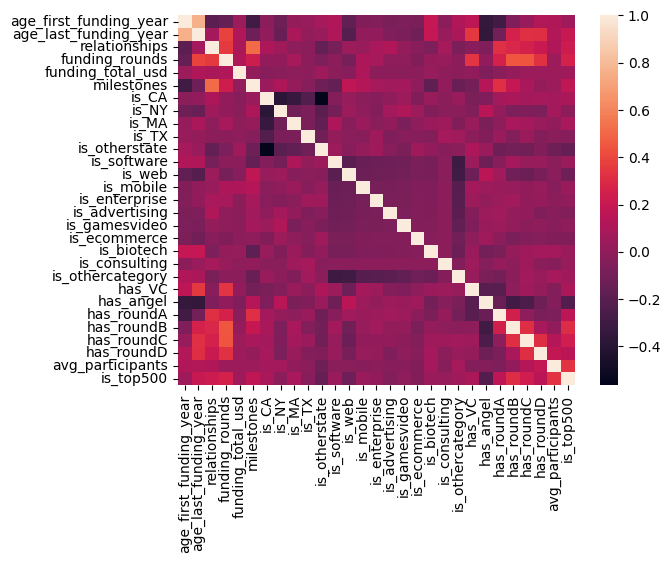

In [34]:
correlation = df_num.corr()
sns.heatmap(correlation, xticklabels=True, yticklabels=True)

As seen in the heatmap above, there is not a noticable amount of positive correlation between any two of the attributes. However, collinearity may be present even when correlation is not. 

VIF (variance inflation factor), a measure of collinearity, can be used to determine how much of a particular attribute can be explained by other attributes. Below, the VIF scores are calculated for the numerical dataset. 

In [32]:
X_num = df_num.iloc[:,:-1]

vif_data = pd.DataFrame()
vif_data['feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(len(X_num.columns))]
vif_data

,feature,VIF
0,age_first_funding_year,6.323189
1,age_last_funding_year,7.466953
2,relationships,1.693966
3,funding_rounds,3.747499
4,funding_total_usd,1.072956
5,milestones,1.664896
6,is_CA,232.849011
7,is_NY,95.746967
8,is_MA,77.304788
9,is_TX,41.495181


A VIF score greater than 10 is typically cause for concern. In this case, all of the potentially problematic variables are Boolean expansions of location or category values. Since these cannot be reasonably reduced and are important to interpretation of the model, they will remain part of the dataset. However, there is no evidence of collinearity between other attributes, which is indicative of good quality when moving forward.

In [30]:
vif_data[vif_data['VIF'] > 10]

,feature,VIF
6,is_CA,232.849011
7,is_NY,95.746967
8,is_MA,77.304788
9,is_TX,41.495181
10,is_otherstate,161.615450
11,is_software,158.442985
12,is_web,149.628227
13,is_mobile,82.701904
14,is_enterprise,76.443986
15,is_advertising,64.956079
